In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
scatter_const=10
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

root_folder = '/content/gdrive/My Drive/deep learning for heat transfer/'

import os
import scipy.io as spio

from matplotlib import pyplot as plt
from matplotlib import colors
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# quick visualization of the geometries
def print2D(array,L,titles):
  B = np.reshape(array[0,:], (-1, L))
  elev_min=np.amin(array[0,:])
  elev_max=np.amax(array[0,:])
  plot_max=max(elev_max,-elev_min)
  mid_val=0
  print(B.shape)
  cmap='bwr'
  plt.figure(figsize=(6,5))
  #plt.pcolor(B,cmap=cmap, clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
  plt.pcolor(B,cmap=cmap, clim=(-plot_max, plot_max), norm=MidpointNormalize(midpoint=mid_val,vmin=-plot_max, vmax=plot_max))
  plt.colorbar()
  plt.title(titles)

def print2D_ax(array,L,titles,ax):
  if array.shape[0]==1:
    B=np.reshape(array, (-1, L))
  else:
    B = np.reshape(array[0,:], (-1, L))
  elev_min=np.amin(array[0,:])
  elev_max=np.amax(array[0,:])
  plot_max=max(elev_max,-elev_min)
  mid_val=0
  cmap='bwr' 
  #plt.pcolor(B,cmap=cmap, clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
  im = ax.pcolor(B,cmap=cmap, clim=(-plot_max, plot_max), norm=MidpointNormalize(midpoint=mid_val,vmin=-plot_max, vmax=plot_max))
  ax.figure.colorbar(im, ax=ax)
  ax.set(title=titles)
  


def plot_confusion_matrix_ax(y_true, y_pred, classes,ax,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             #rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
  
def logitClassify_loop_thre(train_test_set,axs,num,L,T_thre,class_names,plotCM):
    x_train,y_train,x_test,y_test=train_test_set
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression(solver='lbfgs')
    
    logisticRegr.fit(x_train, y_train)

    y_pred2=logisticRegr.predict(x_test)

    logit_weight=logisticRegr.coef_
    g = float("{0:.2f}".format(T_thre))
    print2D_ax(logit_weight,L,'Logistic W of T_thre='+str(g),axs[num])


    if plotCM:
      plot_confusion_matrix_ax(y_test, y_pred2, class_names, axs[num+1],normalize=True,
                          title='Norm. confusion matrix of T_thre='+str(g))
    return logit_weight

def readXY(dirData,L,num_par,num):
  
  mat1 = spio.loadmat(dirData, squeeze_me=True)
  record1 = mat1['record'] # array
  maxT1=record1[:,num_par+1]
  X1=record1[:,num:num+L**2]
  
  return X1, maxT1


    
def plotRank_ax(x,y,titles,ax,size):
  
  im = ax.scatter(x, y, s=size, alpha=0.5)
  ax.set(title=titles)



    
def getTthre(maxT, thre_num,buffer):
  maxInc=np.amax(maxT)
  minInc=np.amin(maxT)
  print("Max Temperature Increase is",str(maxInc))
  print("Min Temperature Increase",str(minInc))
  # visualize the weight

  start=int(math.ceil(minInc / 10.0)) * 10
  end=int(math.floor(maxInc / 10.0)) * 10
  T_thres=np.linspace(start+buffer, end-buffer, thre_num)
  return T_thres


      
def logitClassify_loop_T_R(train_test_set,axs,num,L,T_thre,ratio,class_names,plotCM):

    
    x_train1,y_train1,x_test,y_test=train_test_set
    
    totalDim=x_train1.shape[0]
    #print(totalDim)
    dims=int(totalDim*ratio)
    x_train,y_train=x_train1[:dims,:],y_train1[:dims]
    
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression(solver='lbfgs')
    
    logisticRegr.fit(x_train, y_train)

    y_pred=logisticRegr.predict(x_test)

    logit_weight=logisticRegr.coef_
    g = float("{0:.2f}".format(T_thre))
    print2D_ax(logit_weight,L,'W (T='+str(g)+' Ratio='+str(ratio)+')',axs[num])
    prf=precision_recall_fscore_support(y_test, y_pred, average='binary')
    accu=accuracy_score(y_test,y_pred) 
    #class_names = np.ndarray(['hello','snake','plate'], dtype=str)
    

    # Plot non-normalized confusion matrix
    #axs.append(plot_confusion_matrix(y_test, y_pred2, classes=class_names2, normalize=False,
                          #title='Confusion matrix'))
    
    # Plot normalized confusion matrix
    if plotCM:
      plot_confusion_matrix_ax(y_test, y_pred, class_names, axs[num+1],normalize=True,
                          title='Norm. confusion matrix of T_thre='+str(g))   
    
    return prf, accu
      


def printMetric_ax(train_size,accu3,precision3,recall3,fscore3,titles,ax):
  ax.plot(train_size,accu3,label='Accuracy')
  ax.plot(train_size,precision3,label='Precision')
  ax.plot(train_size,recall3,label='Recall')
  ax.plot(train_size,fscore3,label='F score')
  ax.legend()
  ax.set_xlabel('Training Set Ratio')
  ax.set_ylabel('Metrics')
  ax.set(title=titles)

def plotMetricStudy(metrics,thre_num,T_thres):
  accu3,precision3,recall3,fscore3,train_size=metrics
  cols=thre_num
  rows=1
  image_width=5
  image_height=4
  fig, axs = plt.subplots(rows,cols, figsize=(cols*image_width, rows*image_height), facecolor='w', edgecolor='k')
  fig.subplots_adjust(hspace = .4, wspace=.3)
  axs = axs.ravel()
  for i in range(thre_num):
    T_thre=T_thres[i]
    g = float("{0:.2f}".format(T_thre))
    printMetric_ax(train_size,accu3[:,i],precision3[:,i],recall3[:,i],fscore3[:,i],'T_thre='+str(g),axs[i])


def readXYseries(dirDatas,L,num_par,num):
  flag=1
  for counter, dirData in enumerate(dirDatas):
    X1,maxT1=readXY(dirData,L,num_par,num)
    if flag:
      geo=X1
      maxT=maxT1
      flag=0
    else:
      geo=np.concatenate((geo,X1),axis=0)
      maxT=np.concatenate((maxT,maxT1),axis=0)
  return geo, maxT

def plotWeightCM(L,dirDatas,buffer=0,isSeries=False,plotCM=True,thre_num=4):
  num_par=4
  num_stats=4
  num=num_par+num_stats
  k_num=1
  class_names=['cooled','heated']
  if isSeries:
    geo, maxT=readXYseries(dirDatas,L,num_par,num)
  else:
    geo, maxT=readXY(dirDatas,L,num_par,num)
  T_thres=getTthre(maxT,thre_num,buffer)
  cols=4
  rows=int(thre_num*2/cols)
  fig, axs=initFig(k_num,thre_num,rows,cols)
  

  for k in range(k_num):

    x_train1, x_test1, y_train1, y_test1 = train_test_split(geo, maxT, test_size=0.25, random_state=0)

    for i in range(thre_num):
      T_thre=T_thres[i]
      y_train=np.where(y_train1 > T_thre, 1, 0)
      y_test=np.where(y_test1 > T_thre, 1, 0)
      train_test_set=x_train1,y_train,x_test1,y_test
      seq=2*(k*thre_num+i)
      logitClassify_loop_thre(train_test_set,axs,seq,L,T_thre,class_names,plotCM)
  fig.tight_layout()
  return geo, maxT, T_thres
  
def plotWeightCM_para(L,dirDatas,isSeries=False,buffer=0,thre_num=4,
                      ratio_num=4,image_size=4,image_ratio=1.2,plotCM=False):
  num_par=4
  num_stats=4
  num=num_par+num_stats
  k_num=ratio_num
  ratios=np.linspace(0.1,1,k_num)
  class_names=['cooled','heated']
  image_height=image_size
  image_width=image_size*image_ratio
  if isSeries:
    geo, maxT=readXYseries(dirDatas,L,num_par,num)
  else:
    geo, maxT=readXY(dirDatas,L,num_par,num)
  T_thres=getTthre(maxT,thre_num,buffer)
  rows=thre_num
  cols=4
  fig, axs=initFig(k_num,thre_num,rows,cols,image_height,image_width,hspace = 0.4, wspace=0.4)

  #print2D(geo,L,'Visualize the geometry'
  
  x_train1, x_test1, y_train1, y_test1 = train_test_split(geo, maxT, test_size=0.25, random_state=0)
  
  accu3=np.zeros((k_num,thre_num))
  precision3=np.zeros((k_num,thre_num))
  recall3=np.zeros((k_num,thre_num))
  fscore3=np.zeros((k_num,thre_num))

  for i in range(thre_num):
    T_thre=T_thres[i]
    y_train=np.where(y_train1 > T_thre, 1, 0)
    y_test=np.where(y_test1 > T_thre, 1, 0)
    for k in range(k_num):
      
      train_test_set=x_train1,y_train,x_test1,y_test
      #seq=1*(k*thre_num+i)
      seq=1*(i*k_num+k)
      prf,accu3[k,i]=logitClassify_loop_T_R(train_test_set,axs,seq,L,T_thre,ratios[k],class_names,plotCM)
      precision3[k,i]=prf[1]
      recall3[k,i]=prf[0]
      fscore3[k,i]=prf[2]
    
  metrics=precision3,recall3,fscore3,accu3,ratios
  return metrics, T_thres




def plotRank(geo,maxT,T_thres,thre_num=4,image_height=5):
  
  k_num=1
  cols=4
  rows=int(k_num*thre_num/cols)
  fig,axs=initFig(k_num,thre_num,rows,cols,image_height)
  class_names=['cooled','heated']

  for k in range(k_num):

    x_train1, x_test1, y_train1, y_test1 = train_test_split(geo, maxT, test_size=0.25, random_state=0)

    for i in range(thre_num):
      T_thre=T_thres[i]
      y_train=np.where(y_train1 > T_thre, 1, 0)
      y_test=np.where(y_test1 > T_thre, 1, 0)
      train_test_set=x_train1,y_train,x_test1,y_test,y_test1
      seq=1*(k*thre_num+i)
      logitClassify_loop_thre_rank(train_test_set,axs,seq,L,T_thre)

def printStr(T_thre) :
  g = float("{0:.2f}".format(T_thre))
  return str(g)

def logitClassify_loop_thre_rank(train_test_set,axs,num,L,T_thre):
    x_train,y_train,x_test,y_test,y_test1=train_test_set
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression(solver='lbfgs')
    logisticRegr.fit(x_train, y_train)
    y_pred2=logisticRegr.predict(x_test)
    
    probas = logisticRegr.predict_proba(x_test)
    order1=probas[:,1].argsort()
    rank1=order1.argsort()
    #print(rank1.shape)
    order2=np.argsort(y_test1)
    rank2=np.argsort(order2)
    #print(rank2.shape)
    titles='Ranks of T_thre='+printStr(T_thre)
    size=scatter_const/math.log10(x_test.shape[0])
    #print (size)
    plotRank_ax(rank1,rank2,titles,axs[num],size)
    
def logitClassify_loop_thre_plotCanFEM(num_can,train_test_set,axs,num,L,T_thre):
    x_train,y_train,x_test,y_test,y_test1=train_test_set
    # all parameters not specified are set to their defaults
    #print(rank1.shape)
    order2=np.argsort(y_test1)
    print(y_test1[order2[1]])
    #print (size)
    for i in range(num_can):

      geoCan2=x_test[order2[i],:]

      geoCan2 = np.reshape(geoCan2, (-1,L*L))

      print2D_ax(-geoCan2,L,'FEM Top '+str(i+1),axs[num+i])

      
    
def logitClassify_loop_thre_plotCanML(num_can,train_test_set,axs,num,L,T_thre):
    x_train,y_train,x_test,y_test,y_test1=train_test_set
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression(solver='lbfgs')
    logisticRegr.fit(x_train, y_train)
    y_pred2=logisticRegr.predict(x_test)
    
    probas = logisticRegr.predict_proba(x_test)
    order1=probas[:,1].argsort()

    #print(rank1.shape)
    order2=np.argsort(y_test1)
    #print(y_test1[order2[1]])
    #print(rank2.shape)
    titles='Ranks of T_thre='+printStr(T_thre)
    size=scatter_const/math.log10(x_test.shape[0])
    #print (size)

    for i in range(num_can):
      geoCan1=x_test[order1[i],:]
      geoCan2=x_test[order2[i],:]
      geoCan1 = np.reshape(geoCan1, (-1,L*L))
      geoCan2 = np.reshape(geoCan2, (-1,L*L))
      #print(geoCan1.shape)

      print2D_ax(geoCan1,L,'ML  Top '+str(i+1)+'(T_thre='+printStr(T_thre)+')',axs[num+i])


def initFig(k_num,thre_num,rows=4,cols=4,image_height=4,image_width=5,hspace = 0.3, wspace=0.4):

  fig, axs = plt.subplots(rows,cols, figsize=(cols*image_width, rows*image_height), facecolor='w', edgecolor='k')
  fig.subplots_adjust(hspace, wspace)
  axs = axs.ravel()
  return fig, axs

def plotTopCan(geo,maxT,num_can,T_thres,thre_num=4,image_height=5):
  k_num=1
  cols=num_can
  rows=int(k_num*thre_num+1)
  fig,axs=initFig(k_num,thre_num,rows,cols,image_height)
  class_names=['cooled','heated']

  for k in range(k_num):

    x_train1, x_test1, y_train1, y_test1 = train_test_split(geo, maxT, test_size=0.25, random_state=0)
    
    for i in range(thre_num):
      T_thre=T_thres[i]
      y_train=np.where(y_train1 > T_thre, 1, 0)
      y_test=np.where(y_test1 > T_thre, 1, 0)
      train_test_set=x_train1,y_train,x_test1,y_test,y_test1
      if i==0:
        seq=0;
        logitClassify_loop_thre_plotCanFEM(num_can,train_test_set,axs,seq,L,T_thre)
        seq+=num_can
        logitClassify_loop_thre_plotCanML(num_can,train_test_set,axs,seq,L,T_thre)
      else:
        seq+=num_can
        logitClassify_loop_thre_plotCanML(num_can,train_test_set,axs,seq,L,T_thre)
        
         
def plotWeightCM_export(L,dirDatas,buffer=0,isSeries=False,plotCM=True,thre_num=4):
  num_par=4
  num_stats=4
  num=num_par+num_stats
  k_num=1
  class_names=['cooled','heated']
  if isSeries:
    geo, maxT=readXYseries(dirDatas,L,num_par,num)
  else:
    geo, maxT=readXY(dirDatas,L,num_par,num)
  T_thres=getTthre(maxT,thre_num,buffer)
  cols=4
  rows=int(thre_num*2/cols)
  fig, axs=initFig(k_num,thre_num,rows,cols)
  weights=np.zeros((thre_num,L*L))

  for k in range(k_num):

    x_train1, x_test1, y_train1, y_test1 = train_test_split(geo, maxT, test_size=0.25, random_state=0)

    for i in range(thre_num):
      T_thre=T_thres[i]
      y_train=np.where(y_train1 > T_thre, 1, 0)
      y_test=np.where(y_test1 > T_thre, 1, 0)
      train_test_set=x_train1,y_train,x_test1,y_test
      seq=2*(k*thre_num+i)
      weights[i]=logitClassify_loop_thre(train_test_set,axs,seq,L,T_thre,class_names,plotCM)
  fig.tight_layout()
  return geo, maxT, T_thres, weights     
      
def plotHist(maxT,L,sinkP):
  plt.hist(maxT, bins='auto',density=True)  # arguments are passed to np.histogram
  plt.title("Histogram (L="+str(L)+" Pos="+str(sinkP)+")")
  plt.xlabel('Temperature Increase')
  plt.ylabel('Percentile')
  plt.show()

In [0]:
# genrate a geometry

geoTest=np.zeros(L)

/content/gdrive/My Drive/deep learning for heat transfer/data/Random/L5/num-6/pos-0.5/Records_mesh_1_end_177100_comNum_177100_cRan_L_5_num_6_pad_0_pos_0.5_.mat
Max Temperature Increase is 30.85450553368846
Min Temperature Increase 2.7954305588099486
3.0827483633076165


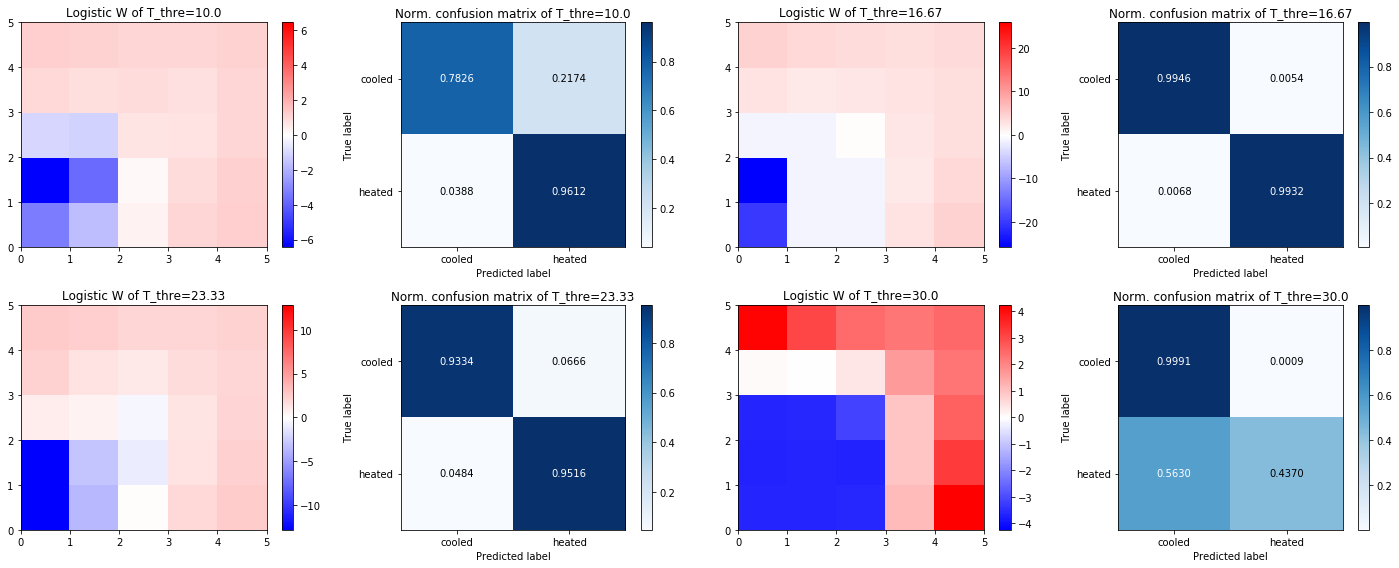

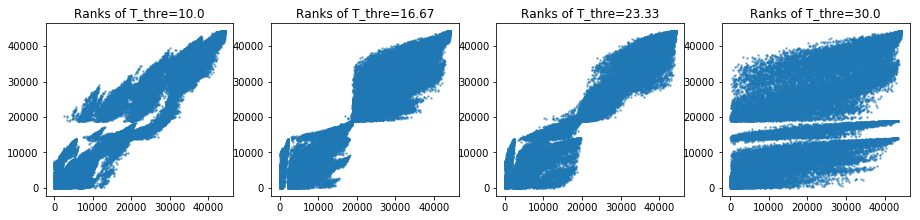

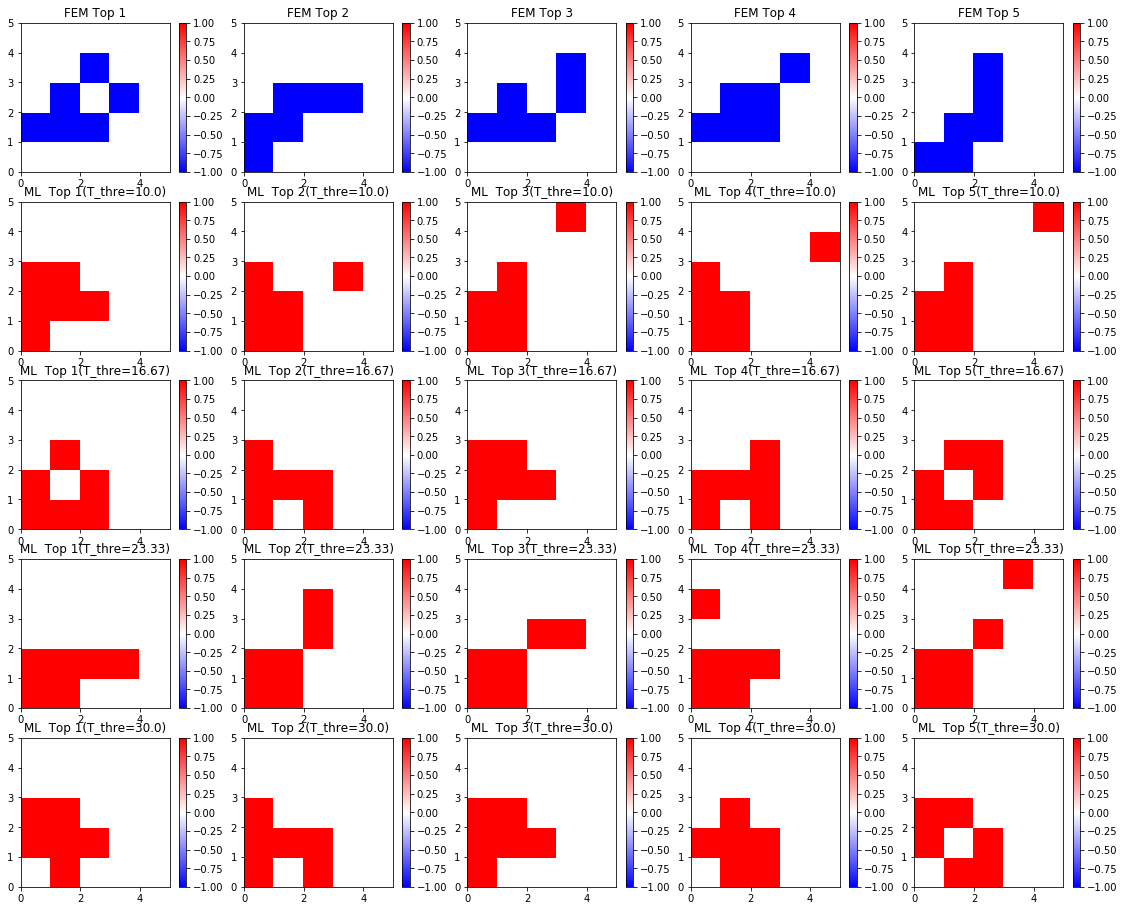

In [0]:
L=5
num_total=6
pos=0.5

num_can=5


num_par=4
num_stats=4
num=num_par+num_stats
dir_folder=root_folder+"data/Random/L"+str(L)+"/num-"+str(num_total)+"/pos-"+str(pos)+"/"
dirData1=(dir_folder+"Records_mesh_1_end_177100_comNum_177100_cRan_L_"+str(L)+"_num_"+str(num_total)+"_pad_0_pos_"+str(pos)+"_.mat")
print(dirData1)


geo,maxT,T_thres=plotWeightCM(L, dirData1,isSeries=False,plotCM=True)
plotRank(geo,maxT,T_thres)
plotTopCan(geo,maxT,num_can,T_thres)

/content/gdrive/My Drive/deep learning for heat transfer/data/Random/L5/num-3/pos-2.5/Records_mesh_1_end_2300_comNum_2300_cRan_L_5_num_3_pad_0_pos_2.5_.mat
Max Temperature Increase is 21.58181600049229
Min Temperature Increase 4.5747333167422966
5.5945355464021365


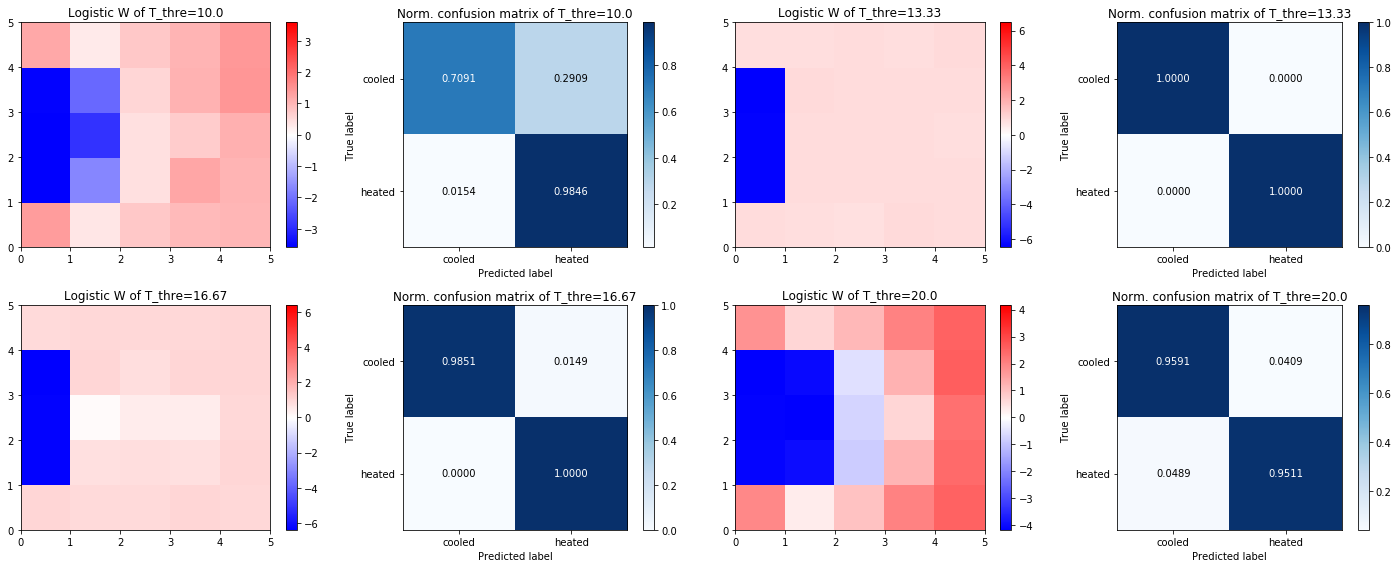

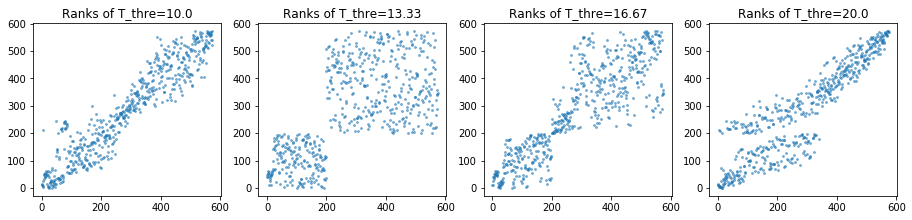

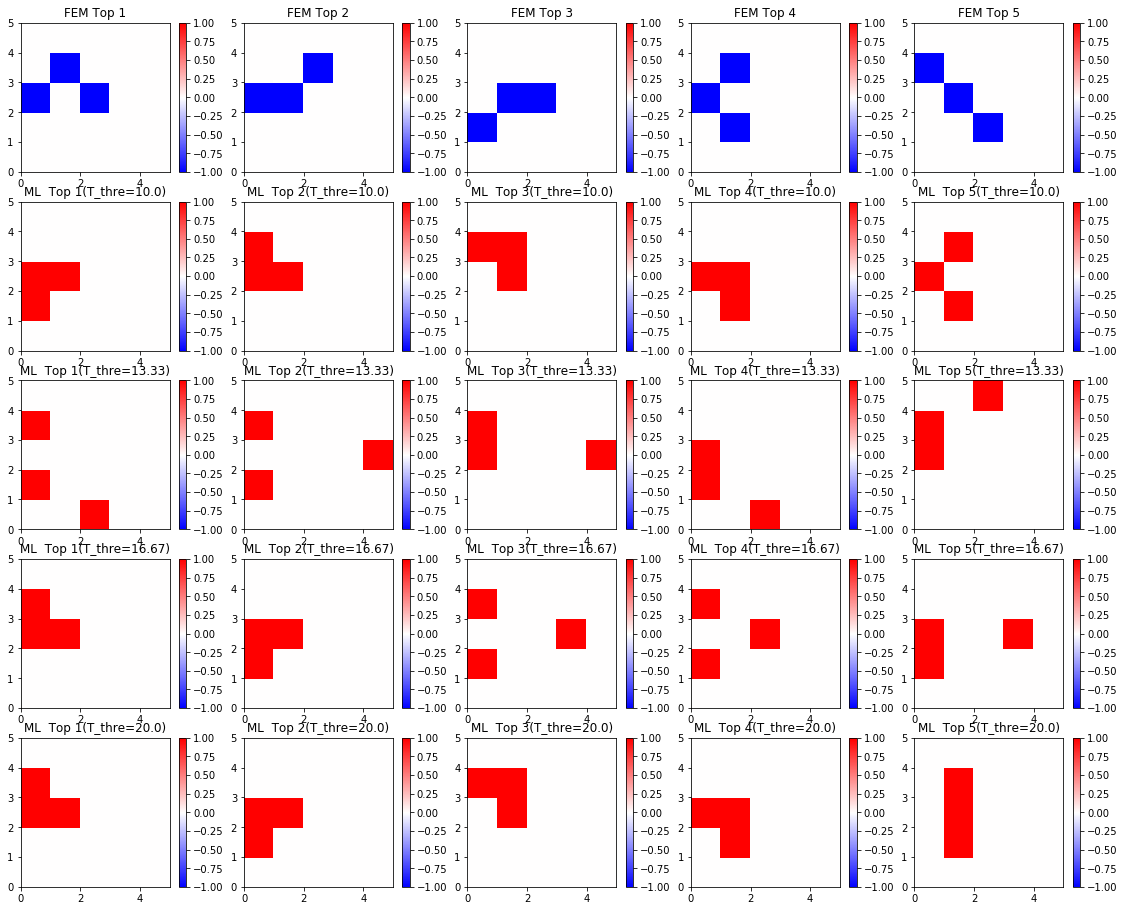

In [0]:
L=5
num_total=3
pos=2.5

num_can=5


num_par=4
num_stats=4
num=num_par+num_stats
dir_folder=root_folder+"data/Random/L"+str(L)+"/num-"+str(num_total)+"/pos-"+str(pos)+"/"
dirData1=(dir_folder+"Records_mesh_1_end_2300_comNum_2300_cRan_L_"+str(L)+"_num_"+str(num_total)+"_pad_0_pos_"+str(pos)+"_.mat")
print(dirData1)


geo,maxT,T_thres=plotWeightCM(L, dirData1,isSeries=False,plotCM=True)
plotRank(geo,maxT,T_thres)
plotTopCan(geo,maxT,num_can,T_thres)

/content/gdrive/My Drive/deep learning for heat transfer/data/Random/L5/num-3/pos-0.5/Records_mesh_1_end_2300_comNum_2300_cRan_L_5_num_3_pad_0_pos_0.5_.mat
Max Temperature Increase is 31.881879078474483
Min Temperature Increase 5.822648213990977
7.823440700850655


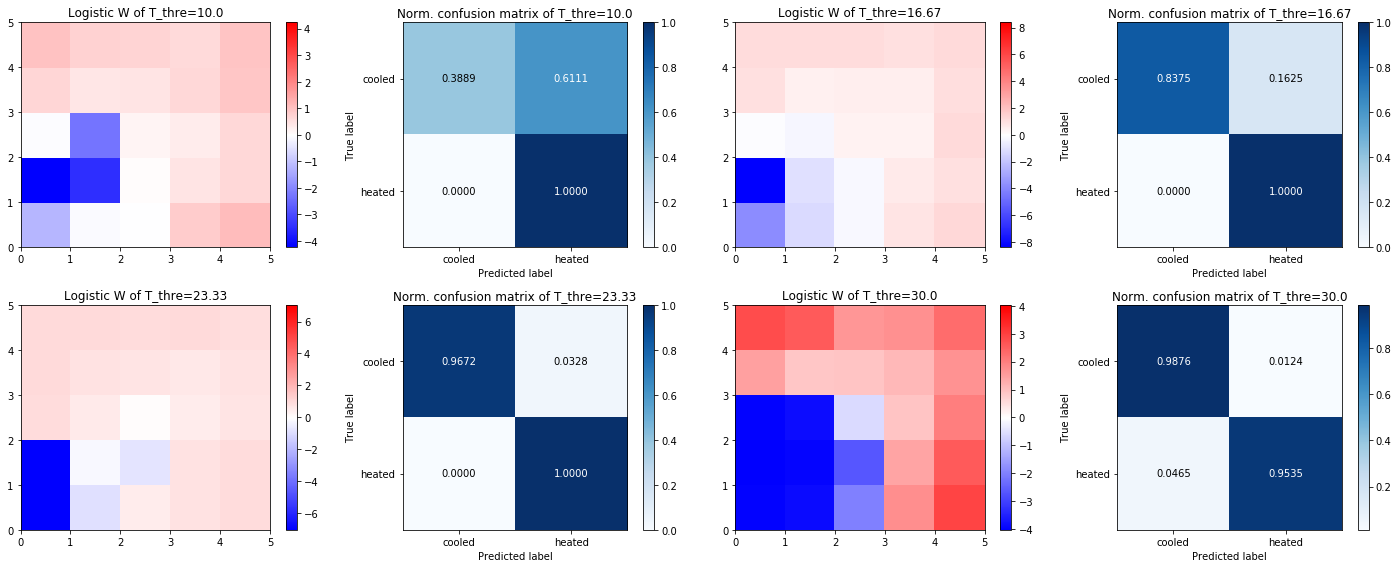

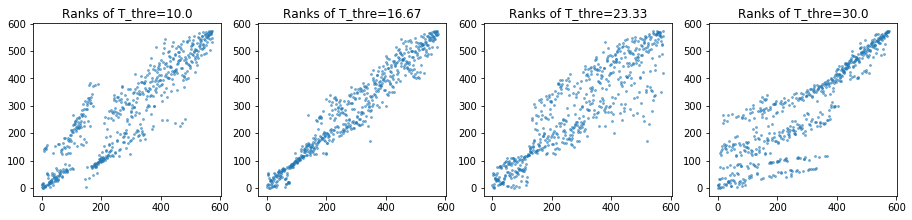

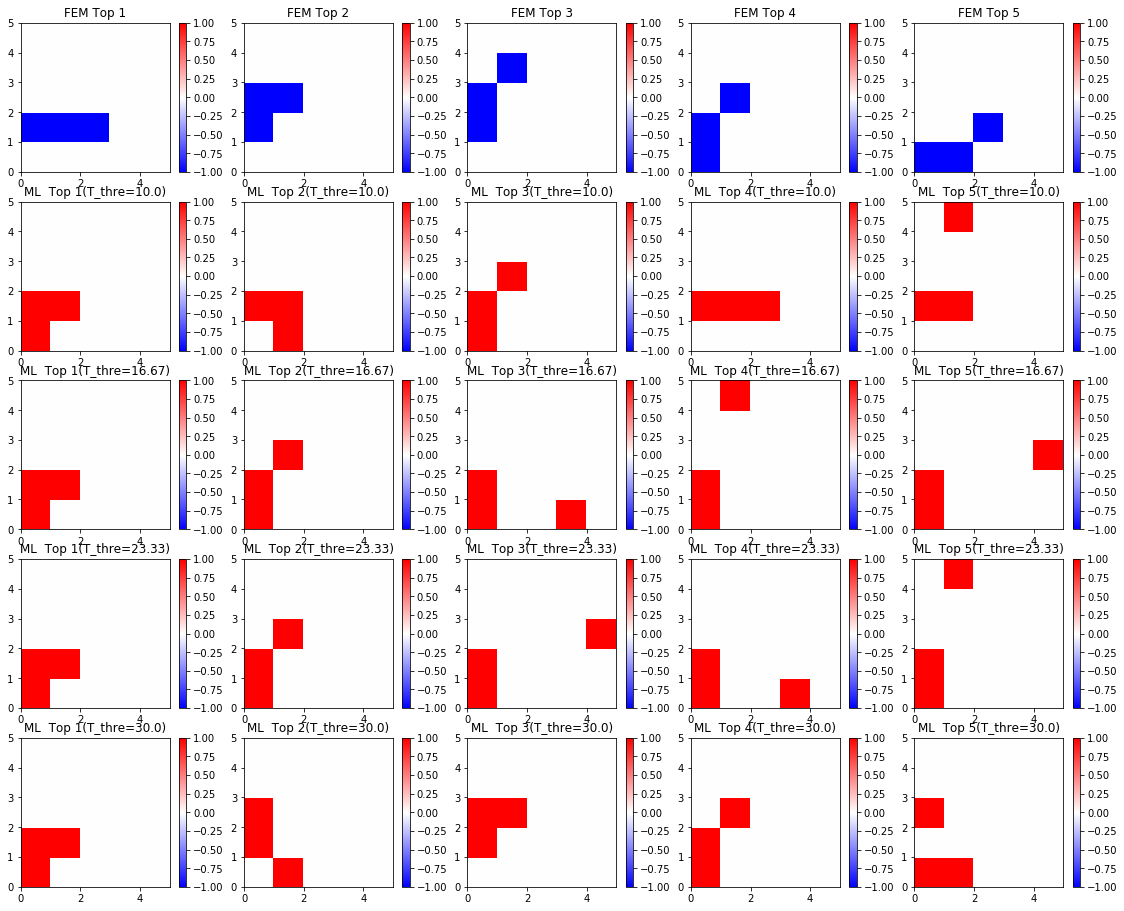

In [0]:
L=5
num_total=3
pos=0.5

num_can=5


num_par=4
num_stats=4
num=num_par+num_stats
dir_folder=root_folder+"data/Random/L"+str(L)+"/num-"+str(num_total)+"/pos-"+str(pos)+"/"
dirData1=(dir_folder+"Records_mesh_1_end_2300_comNum_2300_cRan_L_"+str(L)+"_num_"+str(num_total)+"_pad_0_pos_"+str(pos)+"_.mat")
print(dirData1)


geo,maxT,T_thres=plotWeightCM(L, dirData1,isSeries=False,plotCM=True)
plotRank(geo,maxT,T_thres)
plotTopCan(geo,maxT,num_can,T_thres)